In [1]:
import numpy as np
import pandas as pd
from anndata import AnnData
import scanpy as sc, anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns

import scdrs

from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

seed = 0
np.random.seed(seed)

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


# In[230]:


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = 'pbmc_magic'


import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.6 pynndescent==0.5.4


In [2]:
adata = sc.read('../scanpy/pbmc/pbmc.magic.h5ad')

In [3]:
df_traits = pd.read_csv('../data/supp_table/trait_info.tsv', sep='\t')
df_traits.head()

Trait Name         Trait_Identifier    Code  \
0               Crohn's Disease      PASS_CD_deLange2017      CD   
1                Celiac Disease              PASS_Celiac  Celiac   
2    Inflammatory Bowel Disease     PASS_IBD_deLange2017     IBD   
3  Systemic Lupus Erythematosus               PASS_Lupus     SLE   
4            Multiple Sclerosis  PASS_Multiple_sclerosis      MS   

       Category                             Reference      N        M     h2g  \
0  blood/immune        de Lange et al. 2017 Nat Genet  40266  1150097  0.4152   
1  blood/immune         Dubois et al., 2010 Nat Genet  15283   245449  0.3296   
2  blood/immune        de Lange et al. 2017 Nat Genet  59957  1150510  0.3206   
3  blood/immune        Bentham et al., 2015 Nat Genet  14267   654940  0.4584   
4  blood/immune  IMS Genetics Consortium, 2011 Nature  27148   227549  0.0812   

       sd          Z  Intercept log10 Me Common  
0  0.0361  11.501385     1.1010             NaN  
1  0.0697   4.728838     1.0528             NaN  
2  0.0243  13.193416     1.1216     3.60 (0.04)  
3  0.0957   4.789969     1.0899             NaN  
4  0.0373   2.176944     1.0416             NaN

In [4]:
! seq 0 14 | xargs -P15 -I{} bash ../scripts/scDRS_batch_nofilter_impute_pbmc.sh {}

+ mkdir -p ../scanpy/pbmc/scDRS_nofilter_magic
+ mkdir -p ../scanpy/pbmc/scDRS_nofilter_magic
+ mkdir -p ../scanpy/pbmc/scDRS_nofilter_magic
+ mkdir -p ../scanpy/pbmc/scDRS_nofilter_magic
+ scdrs compute-score --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad --h5ad-species human --gs-file ../data/gs_file/magma_10kb_top1000_zscore.75_traits.batch/batch0.gs --gs-species human --cov-file ../scanpy/pbmc/pbmc.cov.tsv --flag-filter-data False --flag-raw-count False --flag-return-ctrl-raw-score False --flag-return-ctrl-norm-score True --out-folder ../scanpy/pbmc/scDRS_nofilter_magic
+ mkdir -p ../scanpy/pbmc/scDRS_nofilter_magic
+ scdrs compute-score --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad --h5ad-species human --gs-file ../data/gs_file/magma_10kb_top1000_zscore.75_traits.batch/batch1.gs --gs-species human --cov-file ../scanpy/pbmc/pbmc.cov.tsv --flag-filter-data False --flag-raw-count False --flag-return-ctrl-raw-score False --flag-return-ctrl-norm-score True --out-folder ../scanpy/pbmc/scDRS_no

In [5]:
dict_score = {
    row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_nofilter_magic/{row['Trait_Identifier']}.full_score.gz", 
    sep="\t", index_col=0)
    for pos,row in df_traits.iterrows()
}

# dict_score = {
#     row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_nofilter_magic/{row['Trait_Identifier']}.full_score.gz", 
#     sep="\t", index_col=0)
#     for pos,row in df_traits.iterrows()
# }

for trait in dict_score:
    adata.obs[trait] = dict_score[trait]["norm_score"]

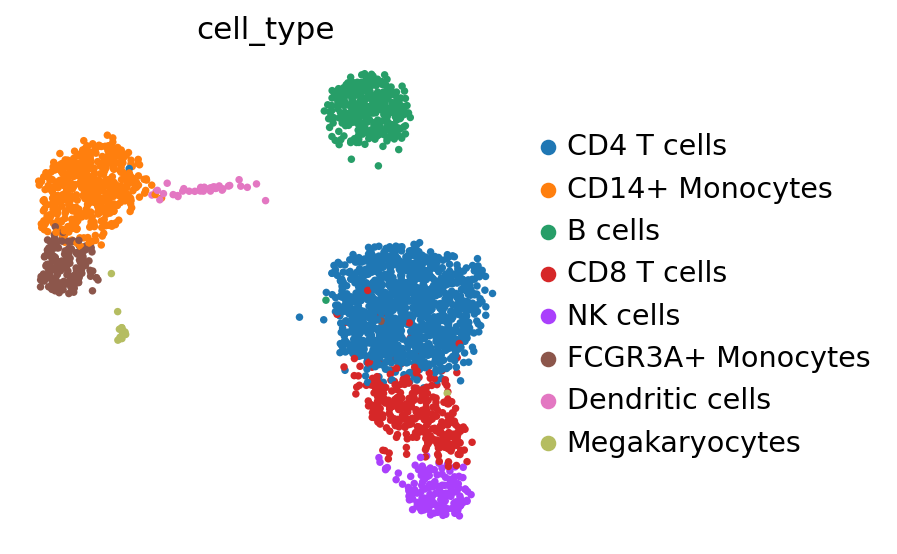

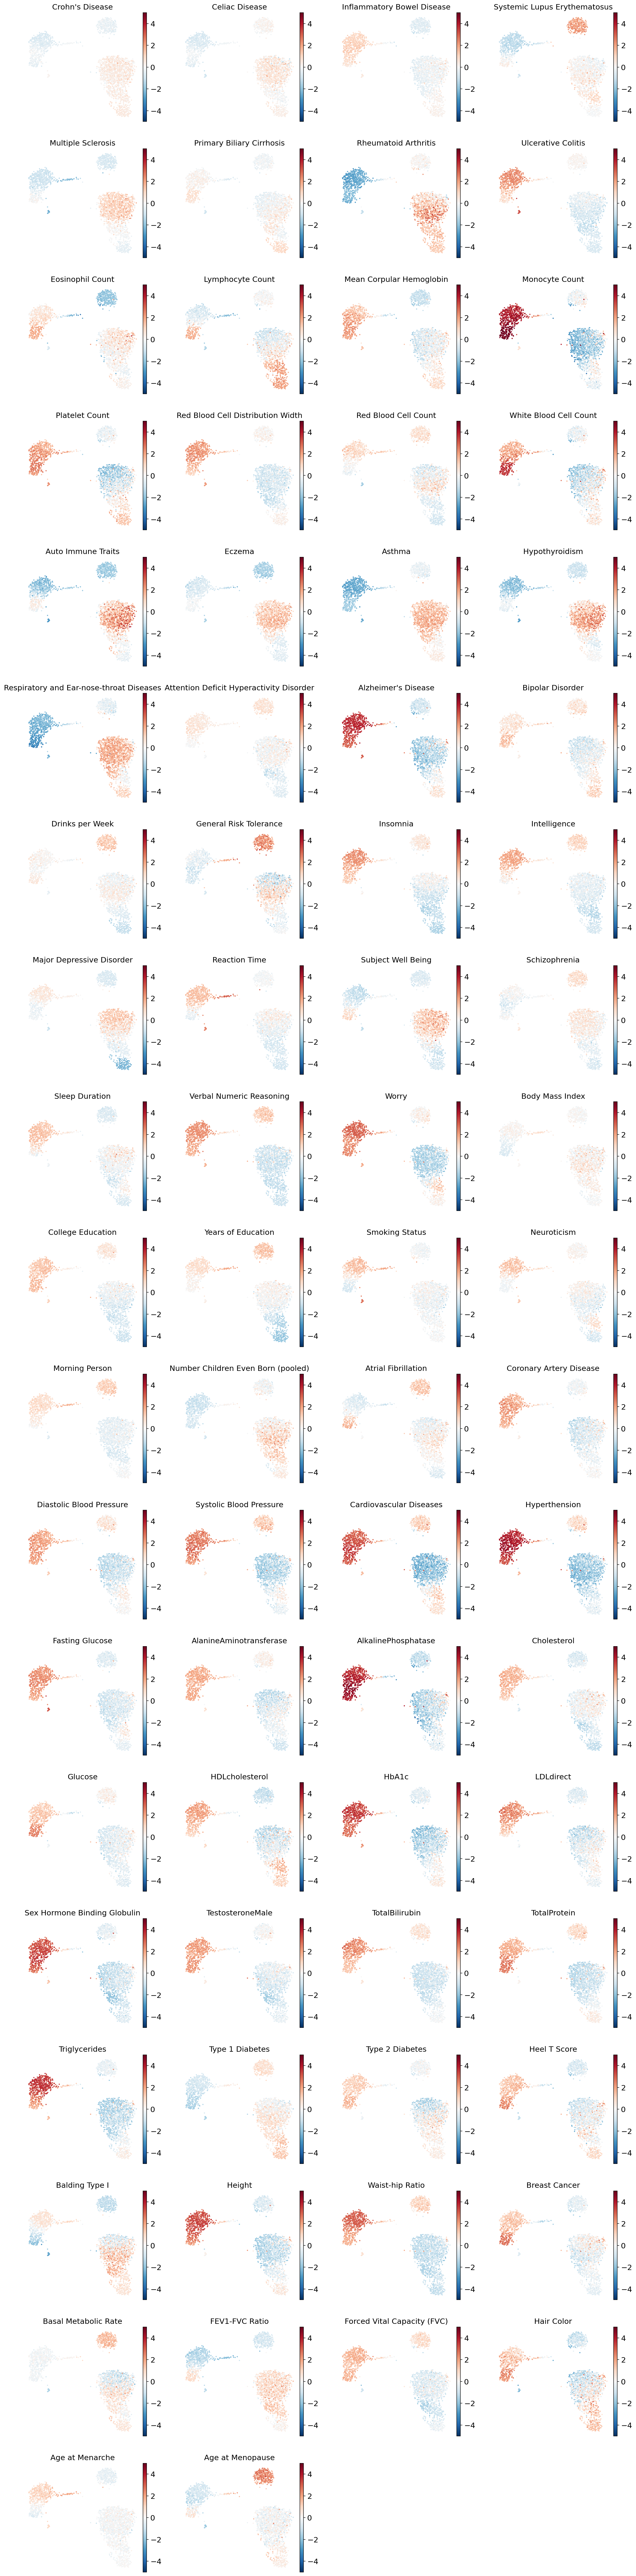

In [6]:
sc.pl.umap(
    adata,
    color="cell_type",
    ncols=1,
    vmin=-5,
    vmax=5,
    save='celltype.png'
)

sc.pl.umap(
    adata,
    color=dict_score.keys(),
    color_map="RdBu_r",
    vmin=-5,
    vmax=5,
    s=20,
    save='disease_scores_magic.png'
)

%%capture

for trait in df_traits['Trait_Identifier']:
    print(```scdrs perform-downstream \
        --h5ad-file ../scanpy/220929_scDRS_various/pbmc.h5ad \
        --score-file ../scanpy/220929_scDRS_various/pbmc/scDRS/{trait}.full_score.gz \
        --out-folder ../scanpy/220929_scDRS_various/pbmc/scDRS \
        --group-analysis cell_type \
        --flag-filter-data True \
        --flag-raw-count True &```)

In [7]:
for trait in df_traits['Trait_Identifier']:
    print('''scdrs perform-downstream \
        --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad \
        --score-file ../scanpy/pbmc/scDRS_nofilter_magic/{}.full_score.gz \
        --out-folder ../scanpy/pbmc/scDRS_nofilter_magic \
        --group-analysis cell_type \
        --flag-filter-data False \
        --flag-raw-count False &'''.format(trait))

scdrs perform-downstream         --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad         --score-file ../scanpy/pbmc/scDRS_nofilter_magic/PASS_CD_deLange2017.full_score.gz         --out-folder ../scanpy/pbmc/scDRS_nofilter_magic         --group-analysis cell_type         --flag-filter-data False         --flag-raw-count False &
scdrs perform-downstream         --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad         --score-file ../scanpy/pbmc/scDRS_nofilter_magic/PASS_Celiac.full_score.gz         --out-folder ../scanpy/pbmc/scDRS_nofilter_magic         --group-analysis cell_type         --flag-filter-data False         --flag-raw-count False &
scdrs perform-downstream         --h5ad-file ../scanpy/pbmc/pbmc.magic.h5ad         --score-file ../scanpy/pbmc/scDRS_nofilter_magic/PASS_IBD_deLange2017.full_score.gz         --out-folder ../scanpy/pbmc/scDRS_nofilter_magic         --group-analysis cell_type         --flag-filter-data False         --flag-raw-count False &
scdrs perform-downstream        

In [8]:
dict_df_stats = {
    row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_nofilter_magic/{row['Trait_Identifier']}.scdrs_group.cell_type", 
    sep="\t", index_col=0)
    for pos,row in df_traits.iterrows()
}

# dict_df_stats = {
#     row['Trait Name']: pd.read_csv(f"../scanpy/pbmc/scDRS_nofilter_magic/{row['Trait_Identifier']}.scdrs_group.cell_type", 
#     sep="\t", index_col=0)
#     for pos,row in df_traits.iterrows()
# }

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/scdrs/util.py:557: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/scdrs/util.py:557: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


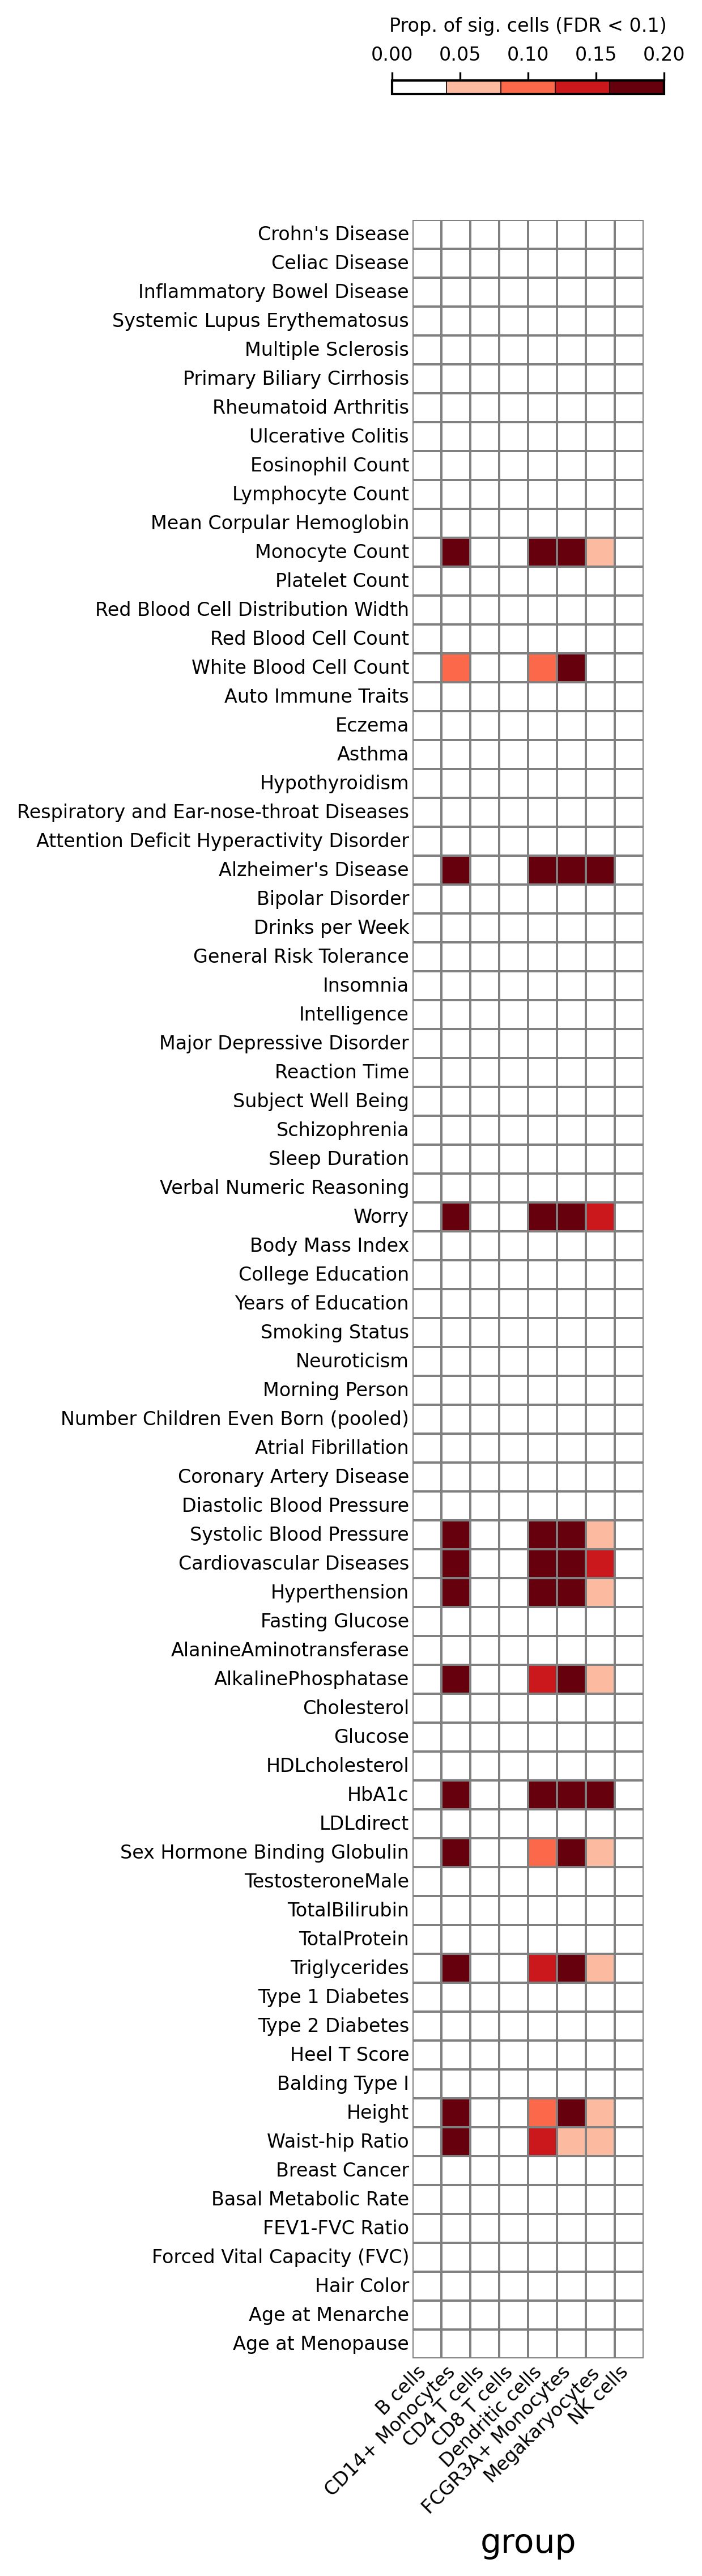

In [9]:
scdrs.util.plot_group_stats(
    {
        trait: df_stats
        for trait, df_stats in dict_df_stats.items()
    }
)
plt.savefig(str(sc.settings.figdir)+'/heatmap_magic.png', bbox_inches='tight')